# 1D Layered Earth model using `SimPEG`



In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
from datetime import datetime
  
# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
import SimPEG
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## define model and survey

In [2]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [4]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z']
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [5]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(res1d))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

Start by defining the underlying tensor mesh. This is the same mesh as is used in the emg3d simulation. 

In [6]:
# mesh_b = discretize.load_mesh("./emg3d_tensor_mesh.json")
mesh_b = discretize.load_mesh("./mesh_layered.json")

In [7]:
mesh_b

TensorMesh: 1,966,080 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    256    -55,672.49     65,474.22     25.00  9,701.72    2.00
   y     80    -51,087.52     51,087.52     25.00 13,166.13    8.00
   z     96    -35,514.71     65,482.02     50.00 19,403.13    1.42

(<matplotlib.collections.QuadMesh at 0x1347da910>,)

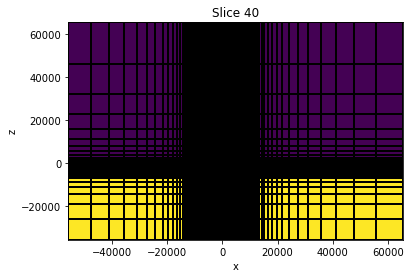

In [8]:
mesh_b.plotSlice(mesh_b.gridCC[:,2]<0., normal='Y', grid=True)

### put the model on the computational mesh

In [9]:
def build_model(mesh):
    rhoh = np.ones(mesh.nC) * res1d[-1]
    rhov = np.ones(mesh.nC) * res1d[-1] *aniso[-1]
    for ii in [3, 2, 1, 0]:
        inds = mesh.gridCC[:,2]>depth[ii]
        rhoh[inds] = res1d[ii]
        rhov[inds] = res1d[ii] *aniso[ii]**2
    return rhoh, rhov

In [10]:
rhoh_b, rhov_b = build_model(mesh_b)

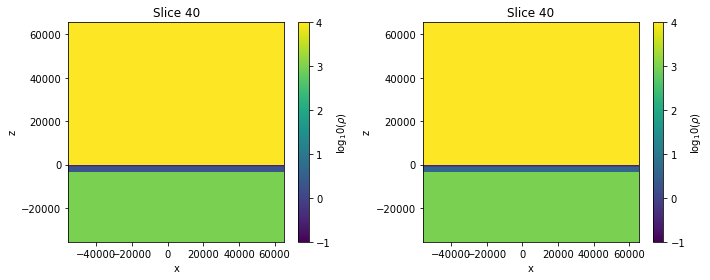

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ii = 3
for a, m, mesh in zip(
    ax.flatten(), 
    [rhoh_b, rhov_b], #rhoh_t, rhov_t], 
    [mesh_b, mesh_b], #mesh_t, mesh_t]
):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y', clim=(-1, 4))[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")

plt.tight_layout()

In [12]:
rho_b = np.vstack([rhoh_b, rhoh_b, rhov_b]).T

## set up the frequency domain simulation

In [13]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [14]:
def build_source(mesh): 
    src_x = np.zeros(mesh.nEx)
    src_inds = (
        (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
        (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
        (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
    )
    src_x[src_inds] = 1
    print(src_inds.nonzero())

    src_vec = strength * mesh.edge * np.hstack([
        src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
    ])
    source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])
    return source

In [16]:
source_b = build_source(mesh_b)

(array([1123198, 1123199, 1123200]),)


In [17]:
survey_b = fdem.Survey([source_b])

In [18]:
sim_b = fdem.Simulation3DElectricField(
    mesh=mesh_b, solver=Pardiso, survey=survey_b, rho=rho_b
)

### Run the simulation

In [19]:
%%time
t0 = time.time()
mem_b = %memit -o fields_b = sim_b.fields()
time_b = time.time()-t0
ram_b = f"{(mem_b.mem_usage[0] - mem_b.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_b}")

peak memory: 287467.25 MiB, increment: 286987.60 MiB
memory usage: 280.261 GiB
CPU times: user 10h 47min 44s, sys: 3min 57s, total: 10h 51min 42s
Wall time: 2h 48min 9s


In [24]:
np.save("simpeg_tensor_fields_rev.npy", fields_b[:, 'e'])

In [25]:
d_b = sim_b.dpred(f=fields_b)  # this uses linear interpolation 

In [26]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = 1/1.5 * np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = 1/1.5 * np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = 1/1.5 * np.vstack([d_re[202:], d_im[202:]]).T
    #1.5 is due to the length of the bipole
    return [d_line1, d_line2, d_line3]

data_b_lines = get_data_lines(d_b)

In [28]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [29]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [30]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_b_lines]).T

# spg_data = np.vstack(data_back_lines).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

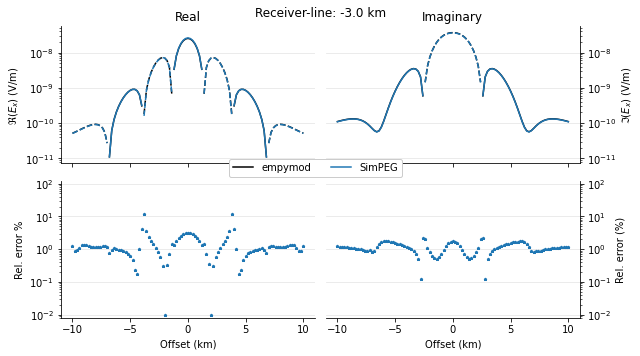

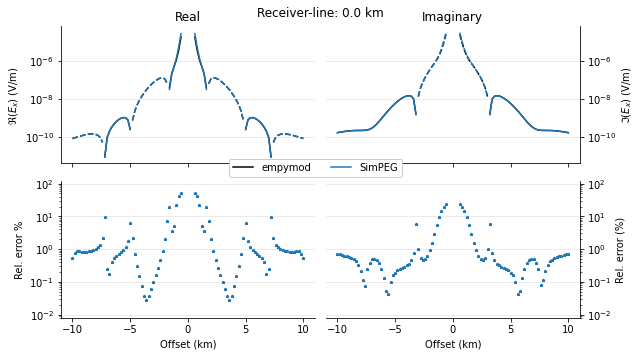

In [32]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C0-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C0--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
    plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

In [33]:
np.median(epm_1d.real)

nan

In [34]:
tmp = epm_1d.real / spg_data.real
1./np.median(tmp[~np.isnan(tmp)])

0.9917677286126642

In [35]:
for i in range(3):
    print(f"Line {i}")
    inds = ~ np.isnan(error['SimPEG'][:, i])
    print(f"mean real: {np.mean(error['SimPEG'][inds, i].real):1.2f}, imag: {np.mean(error['SimPEG'][inds, i].imag):1.2f}")
    print(f"median  real: {np.median(error['SimPEG'][inds, i].real):1.2f}, imag: {np.median(error['SimPEG'][inds, i].imag):1.2f}")             
    print("\n")
                  

Line 0
mean real: 1.48, imag: 1.15
median  real: 1.18, imag: 1.09


Line 1
mean real: 4.10, imag: 2.08
median  real: 0.85, imag: 0.48


Line 2
mean real: 1.48, imag: 1.15
median  real: 1.18, imag: 1.09




In [36]:
save_results = True

In [37]:
if save_results: 
    # Save the three lines
    ds.line_1.data = np.vstack([spg_data[:, 0].real, spg_data[:, 0].imag]).ravel('F')
    ds.line_2.data = np.vstack([spg_data[:, 1].real, spg_data[:, 1].imag]).ravel('F')
    ds.line_3.data = np.vstack([spg_data[:, 2].real, spg_data[:, 2].imag]).ravel('F')

    # Add info
    ds.attrs['runtime'] = time_b
    ds.attrs['n_procs'] = 1
    ds.attrs['max_ram'] = ram_b
    ds.attrs['n_cells'] = f"{mesh_b.nC}"
    ds.attrs['n_nodes'] = 'N/A'
    ds.attrs['n_dof'] = f"{mesh.nE}"
    ds.attrs['extent'] = (f"x = {mesh_b.vectorNx[0]:.1f}-{mesh_b.vectorNx[-1]:.1f}; " # Total mesh extent
                          f"y = {mesh_b.vectorNy[0]:.1f}-{mesh_b.vectorNy[-1]:.1f}; "
                          f"z = {mesh_b.vectorNz[0]:.1f}-{mesh_b.vectorNz[-1]:.1f}")
    ds.attrs['min_vol'] = f"{np.min(mesh_b.vol):.1f}"
    ds.attrs['max_vol'] = f"{np.max(mesh_b.vol):.1f}"
    ds.attrs['machine'] = "GKE n2-custom (8 vCPUs, 320 GB memory); Intel Cascade Lake; Ubuntu-1604-xenial"
    ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
    ds.attrs['date'] = datetime.today().isoformat()

    # Save it under <{model}_{code}.nc>
    ds.to_netcdf(f"../results/layered_simpeg_rev.nc", engine='h5netcdf')

In [13]:
from SimPEG import Report
Report()

--------------------------------------------------------------------------------
  Date: Sun Jan 31 19:09:29 2021 MST

                OS : Darwin
            CPU(s) : 8
           Machine : x86_64
      Architecture : 64bit
               RAM : 16.0 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Jul 31 2020, 02:18:36)
  [Clang 10.0.1 ]

            SimPEG : 0.14.3
        discretize : 0.6.2
       pymatsolver : 0.1.2
        vectormath : 0.2.2
        properties : 0.6.1
             numpy : 1.19.1
             scipy : 1.5.2
            cython : 0.29.21
           IPython : 7.18.1
        matplotlib : 3.3.0
        ipywidgets : 7.5.1

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------